# Manual Feature Engineering on the Retail Dataset

In this notebook we will work on manual feature engineering of a retail dataset. This dataset is originally from the UCI machine learning repository and is reminiscient of real-world data.

In [1]:
import numpy as np
import pandas as pd

import featuretools as ft

In [18]:
data = pd.read_excel('../input/Online Retail.xlsx', names = ['order_id', 'product_id', 'desc', 'quantity', 
                                                             'date', 'unit_price', 'customer_id', 'country'])

print(data.shape)
data = data.drop_duplicates()
print(data.shape)
data.head()


(541909, 8)
(536641, 8)


,order_id,product_id,desc,quantity,date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Prediction Problem

The first step we need to decide is what exactly we want to predict from this data. One question of interest to businesses is: will my customers be repeat buyers? We can answer this by determining whether or not a customer will have more than 2 orders in the next month. To do this, we establish a prediction point for customers: for each customer, we'll identify the last observation in the data, and then go forward a month from this point. We'll then count the number of purchases in that last month of data to find the label.

In [19]:
last_purchase = pd.DataFrame(data.groupby(['customer_id'])['date'].max())
last_purchase['prediction_point'] = [date - pd.Timedelta(30, unit = 'd') for date in last_purchase['date']]
last_purchase.head()

,date,prediction_point
customer_id,,
12346.0,2011-01-18 10:17:00,2010-12-19 10:17:00
12347.0,2011-12-07 15:52:00,2011-11-07 15:52:00
12348.0,2011-09-25 13:13:00,2011-08-26 13:13:00
12349.0,2011-11-21 09:51:00,2011-10-22 09:51:00
12350.0,2011-02-02 16:01:00,2011-01-03 16:01:00


In [20]:
orders = []

# Iterate through each customer
for customer_id, customer_info in last_purchase.iterrows():
    prediction_point = customer_info['prediction_point']
    
    # Subset the data to after the prediction point
    subset = data.loc[(data['date'] > prediction_point) & (data['customer_id'] == customer_id), :].copy()
    
    # Add the number of unique orders in the month to a list
    orders.append(subset['order_id'].nunique())

Now we need to create the labels. This will simply be a boolean indicating whether or not there were more than 2 orders in the final month.

In [21]:
last_purchase['orders'] = orders
last_purchase['label'] = last_purchase['orders'] > 2

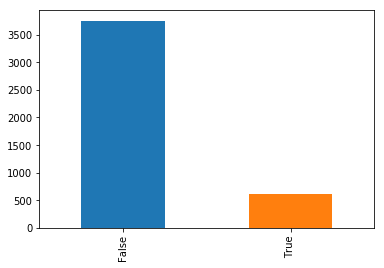

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

last_purchase['label'].value_counts().plot.bar();

## Limit Data to before the Prediction Point

Now that we know the last date we can use for each customer, we have to go back through the `data` and remove any points from the final month of data for the customer.

In [ ]:
usable_data = pd.DataFrame(columns = data.columns)

# Iterate through each customer
for customer_id, row in last_purchase.iterrows():
    subset = data[(data['customer_id'] == customer_id) & (data['date'] > row['prediction_point'])]
    usable_data = usable_data.append(subset, ignore_index = True, sort = False)
    
usable_data.head()

In [ ]:
data = usable_data.copy()
usable_data.to_csv('../input/usable_purchases.csv')

# Normalizing Data

The first step we need to take is get the data into discrete normalized tables. We'll create 4 tables of information:

* customers: each customer (`customter_id`) will have one row
* products: each product (`product_id`) will have one row
* orders: each invoice (`order_id`) will have one row
* purchases: each purchased item will have one row

The purchases dataframe is the child of all the other dataframes. The `customers` dataframe is where we will make our features for the prediction problem. 

In [ ]:
data.head()

### Orders

First we'll create a table of just the orders. Each order is uniquely identified by the `order_id` and also has a date, customer, and country. 

In [ ]:
orders = pd.DataFrame(data.groupby(['order_id', 'date', 'customer_id', 'country'])['quantity'].sum().reset_index())
orders.drop(columns = ['quantity'], inplace = True)
orders.head()

### Customers

Each customer is uniquely identified by the `customer_id`. We can use the last purchase data as the customers table.

In [ ]:
customers = last_purchase.drop(columns = ['date']).reset_index().copy()
customers.head()

### Products

Each product is identified by the `product_id`. The unit price might not stay the same so we cannot associate this with each product.

In [ ]:
products = pd.DataFrame(data['product_id'].unique(), columns = ['product_id'])
products.head()

### Purchases

Each purchase is idenitifed by combination of the `order_id`, the `customer_id`, and the `product_id`. We'll have to be careful about which purchases we use for each customer because we cannot use any data from before the `prediction_point` for each customer. However, we can use information about one customer from after their prediction point for a different customer to create features.

In [ ]:
data.head()

# Feature Engineering

The first steps we can take for feature engineering are to modify columns of the purchases data. For example, we can make a `total_cost` column by multipying the `quantity` by the `unit_price`. We can also find the `weekday`, `month`, `hour`, and `minute` of the purchase.

In [ ]:
import seaborn as sns

data['total_price'] = (data['quantity'] * data['unit_price']).astype(np.float32)
sns.kdeplot(data['total_price']);

In [ ]:
data['total_price'].describe()

There are several negative total prices which are not physically possible. If we look at the original data, this is because there are several orders that were cancelled (identifed by a 'C' preceding the order id). To handle these, we'll remove the cancelled lines themselves but add a flag indicating the order was cancelled.  

In [ ]:
data['order_id'] = data['order_id'].astype(str)
cancelled_order_ids = [x[1:] for x in data['order_id'] if x.startswith('C')]
len(cancelled_order_ids)

In [ ]:
data['cancelled'] = data['order_id'].isin(cancelled_order_ids)
data.shape

In [ ]:
data = data[~data['order_id'].str.startswith('C')]
data.shape

Now we'll set to 0 any of the total value where the order was cancelled.

In [ ]:
data.loc[data['cancelled'], 'total_price'] = np.nan
sns.kdeplot(data['total_price'])

The cancelled orders are not duplicated in the orders table but are instead identified by a 'C' in front of the order id. We'll add a flag indicating if the order was cancelled. 

In [ ]:
orders['order_id'] = orders['order_id'].astype(str)

In [ ]:
orders['cancelled'] = orders['order_id'].str.startswith('C')
orders['cancelled'].value_counts()

To make a feature for customers, we can count the number of cancelled orders and the number of non-cancelled orders.

In [ ]:
cancelled = pd.DataFrame(orders.groupby('customer_id')['cancelled'].sum())
total = pd.DataFrame(orders.groupby('customer_id')['cancelled'].count()).rename(columns = {'cancelled': 'total'})
customer_orders = cancelled.merge(total, on = 'customer_id')
customer_orders['non_cancelled'] = customer_orders['total'] - customer_orders['cancelled']
customer_orders.head()

In [ ]:
customer_orders.describe()

We can try to build a model from just this information and see if it is at all useful! 

In [ ]:
customers.head()

In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(customer_orders, customers['label'],
                                        stratify = customers['label'])

In [ ]:
from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, average = 'weighted')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
model.fit(X, y)

In [ ]:
lengths = data.groupby('customer_id')['date'].apply(lambda x: x.max() - x.min())

In [ ]:
lengths.describe()

In [ ]:
cross_val_score(model, X, y, scoring = scorer, cv = 5)

In [ ]:
model.feature_importances_

In [ ]:
preds

In [ ]:
X_test

In [ ]:
preds = model.predict(X_test)
f1_score(y_test, preds)

In [ ]:
def ecdf(a):
    x = np.sort(a)
    y = np.arange(len(x))/float(len(x))
    return x, y

In [ ]:
x, y = ecdf(data['total_price'])
plt.plot(x, y)

In [ ]:
data.loc[(data['total_price'] < 0) | (data['total_price'] > 10000), 'total_price'] = np.nan
sns.kdeplot(data['total_price']);

In [ ]:
data['weekday'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['minute'] = data['date'].dt.minute
data['hour'] = data['date'].dt.hour

data.head()

In [ ]:
data['weekday'].value_counts().sort_index().plot.bar(color = 'orange');

In [ ]:
data['hour'].value_counts().sort_index().plot.bar(color = 'orange');

Now we can start making features for each customer. As an example, we can count the number of previous orders by the customer. Then, we can divide the number of previous orders by the date between the first and last occurrence of the customer in the data to come up with a rate of purchases. 

In [ ]:
date_limits = usable_data

In [ ]:
orders = orders.merge(data, on = 'order_id', how = 'left'a
                     )
orders.head()

In [ ]:
ft_data = ft.demo.load_retail()
ft_data